In [1]:
#In this notebook we reproduce Figure 4.

In [1]:
#Import relevant namespaces.
import pygsti as gst
import numpy as np
import pygsti.construction.std1Q_XY as Std1Q_XY
import pickle
%matplotlib inline
import matplotlib.pyplot as plt
from pygsti.extras import rpe as RPE
from pygsti.extras.rpe.rpeconfig_GxPi2_GyPi2_UpDn import rpeconfig_GxPi2_GyPi2_UpDn
from __future__ import print_function

Fully specified RPE configuration.


In [4]:
#Declare the particular RPE instance we are interested in
#(X and Y pi/2 rotations)
rpeconfig_inst = rpeconfig_GxPi2_GyPi2_UpDn

In [5]:
#Declare a variety of relevant parameters

angleList = ['alpha','epsilon','theta']
NList = [8,16,32,64,128,256]
maxLengths_1024 = [0,1,2,4,8,16,32,64,128,256,512,1024]
numKs_w_0 = len(maxLengths_1024)

gs_target = Std1Q_XY.gs_target
gs_target.set_all_parameterizations('TP')
maxLengths_1024 = [0,1,2,4,8,16,32,64,128,256,512,1024]
fiducials = Std1Q_XY.fiducials
germs = gst.construction.gatestring_list([('Gy',),
 ('Gy','Gy','Gy','Gx',),
 ('Gy','Gx','Gy','Gx','Gx','Gx',),
 ('Gy','Gx','Gy','Gy','Gx','Gx',),
 ('Gy','Gy','Gy','Gx','Gy','Gx',),
 ('Gx',),
 ('Gx','Gy',),
 ('Gx','Gx','Gy','Gx','Gy','Gy',)])
stringListsGST = gst.construction.make_lsgst_lists(gs_target.gates.keys(), fiducials, fiducials, germs, maxLengths_1024)

numStrsD = {}
numStrsD['RPE'] = [6*i for i in np.arange(1,12)]
numStrsD['GST'] = [len(stringList) for stringList in stringListsGST][1:]

numGSTStrs_1024 = numStrsD['GST'][-1]
numRPEStrs_1024 = numStrsD['RPE'][-1]/3
numGSTClicks_1024 = [numGSTStrs_1024*i for i in [8,16,32,64,128,256]]
numRPEClicks_1024 = [numRPEStrs_1024*i for i in [8,16,32,64,128,256]]

In [6]:
#Load the experimental datasets.
DSGST = gst.io.load_dataset('GST_dataset.txt',cache=True)
DSRPE = gst.io.load_dataset('RPE_dataset.txt',cache=True)

Loading from cache file: GST_dataset.txt.cache
Loading from cache file: RPE_dataset.txt.cache


In [7]:
#Load subsampled GST and RPE results files.
GSTResultsFile = open('GST-Subsampling-Results.pkl','r')
resultsGSTD = pickle.load(GSTResultsFile)
GSTResultsFile.close()

RPEResultsFile = open('RPE-Subsampling-Results.pkl','r')
resultsD = pickle.load(RPEResultsFile)
RPEResultsFile.close()

In [8]:
#Create empty dictionaries to hold various results.

gsEstD = {}
trueD = {}

In [9]:
#Run GST on full experimental dataset; record final angle estimates.
#This should run in a minute or less.
method = 'GST'

baseKey =  ('Exp. N=370',)

DSTemp = DSGST

tempResultsD = {}

resultsGST = gst.do_long_sequence_gst(DSTemp,gs_target,fiducials,fiducials,germs,maxLengths_1024,verbosity=0, gaugeOptParams = {'itemWeights': {'gates':1.0, 'spam':1e-4}})

gsEstD[baseKey] = resultsGST.gatesets

alphaKey = ('alpha','GST')+baseKey
epsilonKey = ('epsilon','GST')+baseKey
thetaKey = ('theta','GST')+baseKey

resultsArray = np.zeros([numKs_w_0,1,3],float)

for angle in angleList:
    key = (angle,'GST')+baseKey
    tempResultsD[key] = resultsArray.copy()

for kInd, k in enumerate(maxLengths_1024):
    gs = gsEstD[baseKey]['iteration estimates'][kInd]#gst.optimize_gauge(gsEstD[baseKey][kInd],'target',targetGateset=gs_target,constrainToTP=True,spamWeight=1e-4)
    tempResultsD[alphaKey][kInd,0,0] = RPE.extract_alpha(gs,rpeconfig_inst)
    tempResultsD[epsilonKey][kInd,0,0] = RPE.extract_epsilon(gs,rpeconfig_inst)
    tempResultsD[thetaKey][kInd,0,0] = RPE.extract_theta(gs,rpeconfig_inst)
    
for angle in angleList:
    trueD[angle] = tempResultsD[(angle,'GST',)+baseKey][-1,0,0]

DEBUG: optimized gate to min frobenius distance 0.000234144
DEBUG: optimized gate to min frobenius distance 0.000195541
DEBUG: optimized vector to min frobenius distance 0.000107997


In [10]:
#Define auxiliary functions, taken from PRA 92, 062315.

#Equation 5.16 from PRA 92, 062315; we have relabeled M_j as N to be consistent with our notation.
def pmax_516(N,delta):
    return np.min([1,
           (1-.5*(1-np.sqrt(8)*delta)**2)**N / 
           (np.sqrt(2 * np.pi)*(1-np.sqrt(8)*delta)*np.sqrt(N))])

#Equations 5.7 and 5.8 from PRA 92, 062315.
def xi(h):
    return 2*np.pi/2**h

def xi_bar(K):
    return 2*np.pi/2**(K+1)

#Equation 5.9 from PRA 92, 062315.
def RMSE(K,N,delta):
    return np.sqrt(
        (1-pmax_516(N,delta))*xi_bar(K)**2+np.sum(xi(j)*pmax_516(N,delta) for j in xrange(1,K+1)))

In [11]:
#Compute RMS error values.

angle='alpha'
RMSdataD = {}
for N in [8,16,32,64,128,256]:
    method = 'GST'
    expKey = ('method',method,'N',N)
    RMSdataD[method,N] = np.sqrt(np.mean(np.abs(trueD[angle] - resultsGSTD[(angle,)+expKey][:,:,0])**2,axis=1))
    method = 'RPE'
    expKey = ('method',method,'N',N)
    RMSdataD[method,N] = np.sqrt(np.mean(resultsD[(angle,)+expKey][:,:,0]**2,axis=1))

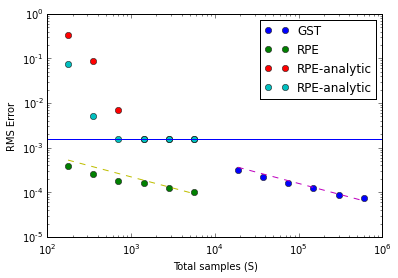

In [12]:
#Plot Figure 4.
method = 'GST'
plt.plot(numGSTClicks_1024,[RMSdataD[method,N][-1] for N in [8,16,32,64,128,256]],'o',label=method)

method = 'RPE'
plt.plot(numRPEClicks_1024,[RMSdataD[method,N][-1] for N in [8,16,32,64,128,256]],'o',label=method)

delta = 0.1
plt.plot(numRPEClicks_1024,[RMSE(11,N,delta) for N in [8,16,32,64,128,256]],'o',label='RPE-analytic')

delta = 0.01
plt.plot(numRPEClicks_1024,[RMSE(11,N,delta) for N in [8,16,32,64,128,256]],'o',label='RPE-analytic')

plt.axhline(np.pi/(2*1024))

plt.plot(numGSTClicks_1024,0.05/np.sqrt(np.array(numGSTClicks_1024)),'--')
plt.plot(numRPEClicks_1024,0.007/np.sqrt(np.array(numRPEClicks_1024)),'--')


plt.yscale('log')
plt.xscale('log')
plt.legend()
plt.xlabel('Total samples (S)')
plt.ylabel('RMS Error')

In [13]:
#Print RPE portion of data for Figure 4.
NList = [8,16,32,64,128,256]
method = 'RPE'
print("RPE clicks\t", 'RPE RMSE-exp\t\t', 'RPE RMSE-analytical-delta=0.1\t', 'RPE RMSE-analytical-delta=0.01\t')
for i, clicks in enumerate(numRPEClicks_1024):
    print(clicks, '\t\t', RMSdataD[method,NList[i]][-1], '\t', RMSE(11,NList[i],0.1), '\t\t\t', RMSE(11,NList[i],0.01))

RPE clicks	 RPE RMSE-exp		 RPE RMSE-analytical-delta=0.1	 RPE RMSE-analytical-delta=0.01	
176 		 0.000389427861598 	 0.338416131323 			 0.0741557010555
352 		 0.000257028532063 	 0.0866651725016 			 0.00507837371573
704 		 0.000177234104431 	 0.00692802640693 			 0.00153417718035
1408 		 0.000162416202037 	 0.00153475813111 			 0.00153398078789
2816 		 0.000124648110357 	 0.00153398078789 			 0.00153398078789
5632 		 0.000104106145407 	 0.00153398078789 			 0.00153398078789


In [14]:
#Print GST portion of data for Figure 4.
NList = [8,16,32,64,128,256]
method = 'GST'
print("GST clicks\t", 'GST RMSE')
for i, clicks in enumerate(numGSTClicks_1024):
    print(clicks, '\t\t', RMSdataD[method,NList[i]][-1])

GST clicks	 GST RMSE
18776 		 0.000324090080012
37552 		 0.000224809323604
75104 		 0.00015785107489
150208 		 0.000128057802701
300416 		 8.57905213441e-05
600832 		 7.43346387288e-05
